In [8]:
import os
import glob
import ddsp.training
from matplotlib import pyplot as plt
import IPython.display as ipd
import gin
import numpy as np
import utils
import tensorflow as tf

%matplotlib inline
sample_rate = 16000

## Set paths

### This DRIVE_DIR must includes your audio files

In [111]:
DRIVE_DIR = './Pretrained_ Models_for_T2/training' 
assert os.path.exists(DRIVE_DIR)

In [ ]:
# create all directories leading up to the given directory that do not exist already. 
# If the given directory already exists, ignore the error.
DATA_DIR = os.path.join(DRIVE_DIR, 'data')
!mkdir -p "$DATA_DIR"
AUDIO_DIR = os.path.join(DATA_DIR, 'audio')
AUDIO_FILEPATTERN = AUDIO_DIR + '/*'
!mkdir -p "$AUDIO_DIR"
# folder to save the model
SAVE_DIR = os.path.join(DRIVE_DIR, 'ddsp-solo-instrument')
!mkdir -p "$SAVE_DIR"

## Prepare Dataset


In [14]:
mp3_files = glob.glob(os.path.join(DRIVE_DIR, '*.mp3'))
wav_files = glob.glob(os.path.join(DRIVE_DIR, '*.wav'))
audio_files = mp3_files + wav_files

for fname in audio_files:
  target_name = os.path.join(AUDIO_DIR, 
                             os.path.basename(fname).replace(' ', '_'))
  print('Copying {} to {}'.format(fname, target_name))
  !cp "$fname" "$target_name"

Copying Pretrained_ Models_for_T2/training/sax_1.wav to Pretrained_ Models_for_T2/training/data/audio/sax_1.wav


In [17]:
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
!mkdir -p "$TRAIN_DIR"
TRAIN_TFRECORD = TRAIN_DIR + '/train.tfrecord'

!ddsp_prepare_tfrecord \
--input_audio_filepatterns="$AUDIO_FILEPATTERN "\
--output_tfrecord_path="$TRAIN_TFRECORD" \
--num_shards=10 \
--alsologtostderr

I0321 12:09:56.917494 4562664960 translations.py:641] ==================== <function annotate_downstream_side_inputs at 0x7fc8019e6dc0> ====================
I0321 12:09:56.918060 4562664960 translations.py:641] ==================== <function fix_side_input_pcoll_coders at 0x7fc8019e6ee0> ====================
I0321 12:09:56.918602 4562664960 translations.py:641] ==================== <function lift_combiners at 0x7fc8019e81f0> ====================
I0321 12:09:56.918938 4562664960 translations.py:641] ==================== <function expand_sdf at 0x7fc8019e83a0> ====================
I0321 12:09:56.919265 4562664960 translations.py:641] ==================== <function expand_gbk at 0x7fc8019e8430> ====================
I0321 12:09:56.919642 4562664960 translations.py:641] ==================== <function sink_flattens at 0x7fc8019e8550> ====================
I0321 12:09:56.919800 4562664960 translations.py:641] ==================== <function greedily_fuse at 0x7fc8019e85e0> ====================


In [104]:
TRAIN_TFRECORD_FILEPATTERN = TRAIN_DIR + '/train.tfrecord*'
print(TRAIN_TFRECORD_FILEPATTERN )
tfre_files = glob.glob(TRAIN_DIR + '/train.tfrecord*')
print(tfre_files)

Pretrained_ Models_for_T2/training/data/train/train.tfrecord*
['Pretrained_ Models_for_T2/training/data/train/train.tfrecord-00001-of-00010', 'Pretrained_ Models_for_T2/training/data/train/train.tfrecord-00000-of-00010', 'Pretrained_ Models_for_T2/training/data/train/train.tfrecord-00006-of-00010', 'Pretrained_ Models_for_T2/training/data/train/train.tfrecord-00007-of-00010', 'Pretrained_ Models_for_T2/training/data/train/train.tfrecord-00008-of-00010', 'Pretrained_ Models_for_T2/training/data/train/train.tfrecord-00009-of-00010', 'Pretrained_ Models_for_T2/training/data/train/train.tfrecord-00002-of-00010', 'Pretrained_ Models_for_T2/training/data/train/train.tfrecord-00003-of-00010', 'Pretrained_ Models_for_T2/training/data/train/train.tfrecord-00005-of-00010', 'Pretrained_ Models_for_T2/training/data/train/train.tfrecord-00004-of-00010']


In [93]:
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)
PICKLE_FILE_PATH = os.path.join(SAVE_DIR, 'dataset_statistics.pkl')

utils.save_dataset_statistics(data_provider, PICKLE_FILE_PATH, batch_size=1)

Calculating dataset statistics for <ddsp.training.data.TFRecordProvider object at 0x7f949d6fbfd0>
Computing statistics for 57 examples.
Done! Saved to: Pretrained_ Models_for_T2/training/ddsp-solo-instrument/dataset_statistics.pkl


Let's load the dataset in the `ddsp` library and have a look at one of the examples.

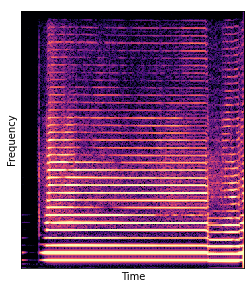

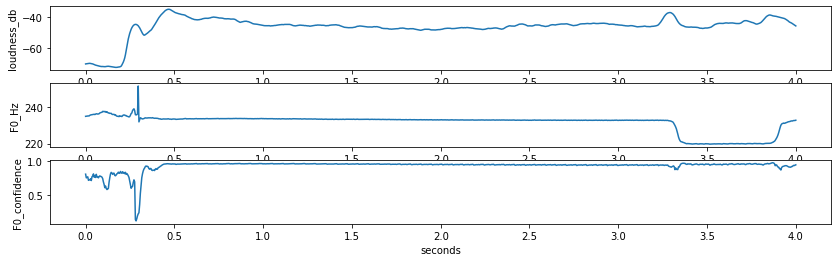

In [94]:
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_dataset(shuffle=False)

try:
  ex = next(iter(dataset))
except StopIteration:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

utils.specplot(ex['audio'])

f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')
ax[1].plot(x, ex['f0_hz'])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'])


In [95]:
ipd.Audio(ex['audio'], rate = sample_rate)

## Train Model

We will now train a "solo instrument" model. This means the model is conditioned only on the fundamental frequency (f0) and loudness with no instrument ID or latent timbre feature. If you uploaded audio of multiple instruemnts, the neural network you train will attempt to model all timbres, but will likely associate certain timbres with different f0 and loudness conditions. 

In [96]:
%reload_ext tensorboard
import tensorboard as tb
tb.notebook.start('--logdir "{}"'.format(SAVE_DIR))

Reusing TensorBoard on port 6006 (pid 38620), started 0:51:23 ago. (Use '!kill 38620' to kill it.)

### We will now begin training. 

Note that we specify [gin configuration](https://github.com/google/gin-config) files for the both the model architecture ([solo_instrument.gin](TODO)) and the dataset ([tfrecord.gin](TODO)), which are both predefined in the library. You could also create your own. We then override some of the spefic params for `batch_size` (which is defined in in the model gin file) and the tfrecord path (which is defined in the dataset file). 

### Training Notes:
* Models typically perform well when the loss drops to the range of ~4.5-5.0.
* Depending on the dataset this can take anywhere from 5k-30k training steps usually.
* The default is set to 30k, but you can stop training at any time, and for timbre transfer, it's best to stop before the loss drops too far below ~5.0 to avoid overfitting.
* On the colab GPU, this can take from around 3-20 hours. 
* We **highly recommend** saving checkpoints directly to your drive account as colab will restart naturally after about 12 hours and you may lose all of your checkpoints.
* By default, checkpoints will be saved every 300 steps with a maximum of 10 checkpoints (at ~60MB/checkpoint this is ~600MB). Feel free to adjust these numbers depending on the frequency of saves you would like and space on your drive.
* If you're restarting a session and `DRIVE_DIR` points a directory that was previously used for training, training should resume at the last checkpoint.

In [ ]:
!ddsp_run \
  --mode=train \
  --alsologtostderr \
  --save_dir="$SAVE_DIR" \
  --gin_file=models/ae.gin \
  --gin_file=datasets/tfrecord.gin \
  --gin_param="TFRecordProvider.file_pattern='./Pretrained_ Models_for_T2/training/data/train/train.tfrecord*'"\
  --gin_param="batch_size=16" \
  --gin_param="train_util.train.num_steps=30000" \
  --gin_param="train_util.train.steps_per_save=300" \
  --gin_param="trainers.Trainer.checkpoints_to_keep=10"

# TFRecordProvider: https://github.com/magenta/ddsp/blob/master/ddsp/training/data.py


I0321 13:24:06.969992 4613684736 ddsp_run.py:176] Restore Dir: 
I0321 13:24:06.970589 4613684736 ddsp_run.py:177] Save Dir: 
I0321 13:24:06.970865 4613684736 resource_reader.py:50] system_path_file_exists:optimization/base.gin
E0321 13:24:06.971374 4613684736 resource_reader.py:55] Path not found: optimization/base.gin
I0321 13:24:06.974587 4613684736 resource_reader.py:50] system_path_file_exists:eval/basic.gin
E0321 13:24:06.974906 4613684736 resource_reader.py:55] Path not found: eval/basic.gin
I0321 13:24:06.978890 4613684736 resource_reader.py:50] system_path_file_exists:models/ae.gin
E0321 13:24:06.979323 4613684736 resource_reader.py:55] Path not found: models/ae.gin
I0321 13:24:06.989346 4613684736 resource_reader.py:50] system_path_file_exists:datasets/tfrecord.gin
E0321 13:24:06.991310 4613684736 resource_reader.py:55] Path not found: datasets/tfrecord.gin
I0321 13:24:06.992500 4613684736 resource_reader.py:50] system_path_file_exists:datasets/base.gin
E0321 13:24:06.993217 4

## Resynthesis

Check how well the model reconstructs the training data

In [63]:
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
dataset = data_provider.get_batch(batch_size=1, shuffle=False)

try:
  batch = next(iter(dataset))
except OutOfRangeError:
  raise ValueError(
      'TFRecord contains no examples. Please try re-running the pipeline with '
      'different audio file(s).')

# Parse the gin config.
gin_file = os.path.join(SAVE_DIR, 'operative_config-0.gin')
gin.parse_config_file(gin_file)

# Load model
model = ddsp.training.models.Autoencoder()
model.restore(SAVE_DIR)

# Resynthesize audio.
outputs = model(batch, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
audio = batch['audio']

print('Original Audio')
specplot(audio)

print('Resynthesis')
specplot(audio_gen)
play(audio_gen)

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:
print('Original Audio')
ipd.Audio(audio[0], rate = sample_rate)

In [ ]:
print('Resynthesis')
ipd.Audio(audio_gen[0], rate = sample_rate)

## Download Checkpoint

Below you can download the final checkpoint. You are now ready to use it in the [DDSP Timbre Tranfer Colab](https://colab.research.google.com/github/magenta/ddsp/blob/master/ddsp/colab/demos/timbre_transfer.ipynb).

In [ ]:
CHECKPOINT_ZIP = 'my_solo_instrument.zip'
latest_checkpoint_fname = os.path.basename(tf.train.latest_checkpoint(SAVE_DIR))
!cd "$SAVE_DIR" && zip $CHECKPOINT_ZIP $latest_checkpoint_fname* operative_config-0.gin dataset_statistics.pkl
!cp "$SAVE_DIR/$CHECKPOINT_ZIP" ./ #copy
# colab_utils.download(CHECKPOINT_ZIP)